<a href="https://colab.research.google.com/github/JuanPabl07DP/Cardiovascular_CNN/blob/main/Cardiovascular_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import glob
import random
import shutil
from pathlib import Path

# Descargar el dataset
path = kagglehub.dataset_download("danialsharifrazi/cad-cardiac-mri-dataset")
print("Path to dataset files:", path)

# Definir las rutas a las carpetas de imágenes
normal_dir = os.path.join(path, 'Normal')
sick_dir = os.path.join(path, 'Sick')

# Verificar las rutas
print(f"Ruta a imágenes normales: {normal_dir}")
print(f"Ruta a imágenes de pacientes con CAD: {sick_dir}")

100%|██████████| 2.86G/2.86G [00:36<00:00, 83.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/danialsharifrazi/cad-cardiac-mri-dataset/versions/2
Ruta a imágenes normales: /root/.cache/kagglehub/datasets/danialsharifrazi/cad-cardiac-mri-dataset/versions/2/Normal
Ruta a imágenes de pacientes con CAD: /root/.cache/kagglehub/datasets/danialsharifrazi/cad-cardiac-mri-dataset/versions/2/Sick


In [5]:
# Función para obtener todas las rutas de imágenes de un directorio
def get_image_paths(directory):
    image_paths = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_paths.extend(glob.glob(os.path.join(directory, '**', ext), recursive=True))
    return image_paths

# Obtener todas las rutas de imágenes
normal_paths = get_image_paths(normal_dir)
sick_paths = get_image_paths(sick_dir)

print(f"Encontradas {len(normal_paths)} imágenes normales")
print(f"Encontradas {len(sick_paths)} imágenes con CAD")

# Balancear el dataset usando todas las imágenes de la clase minoritaria
min_count = min(len(normal_paths), len(sick_paths))
print(f"Para balancear las clases, usaremos {min_count} imágenes de cada clase")

# Seleccionar subconjuntos balanceados
if len(normal_paths) > min_count:
    random.seed(42)
    normal_paths = random.sample(normal_paths, min_count)

if len(sick_paths) > min_count:
    random.seed(42)
    sick_paths = random.sample(sick_paths, min_count)

print(f"Imágenes normales a procesar: {len(normal_paths)}")
print(f"Imágenes CAD a procesar: {len(sick_paths)}")

Encontradas 37564 imágenes normales
Encontradas 25861 imágenes con CAD
Para balancear las clases, usaremos 25861 imágenes de cada clase
Imágenes normales a procesar: 25861
Imágenes CAD a procesar: 25861


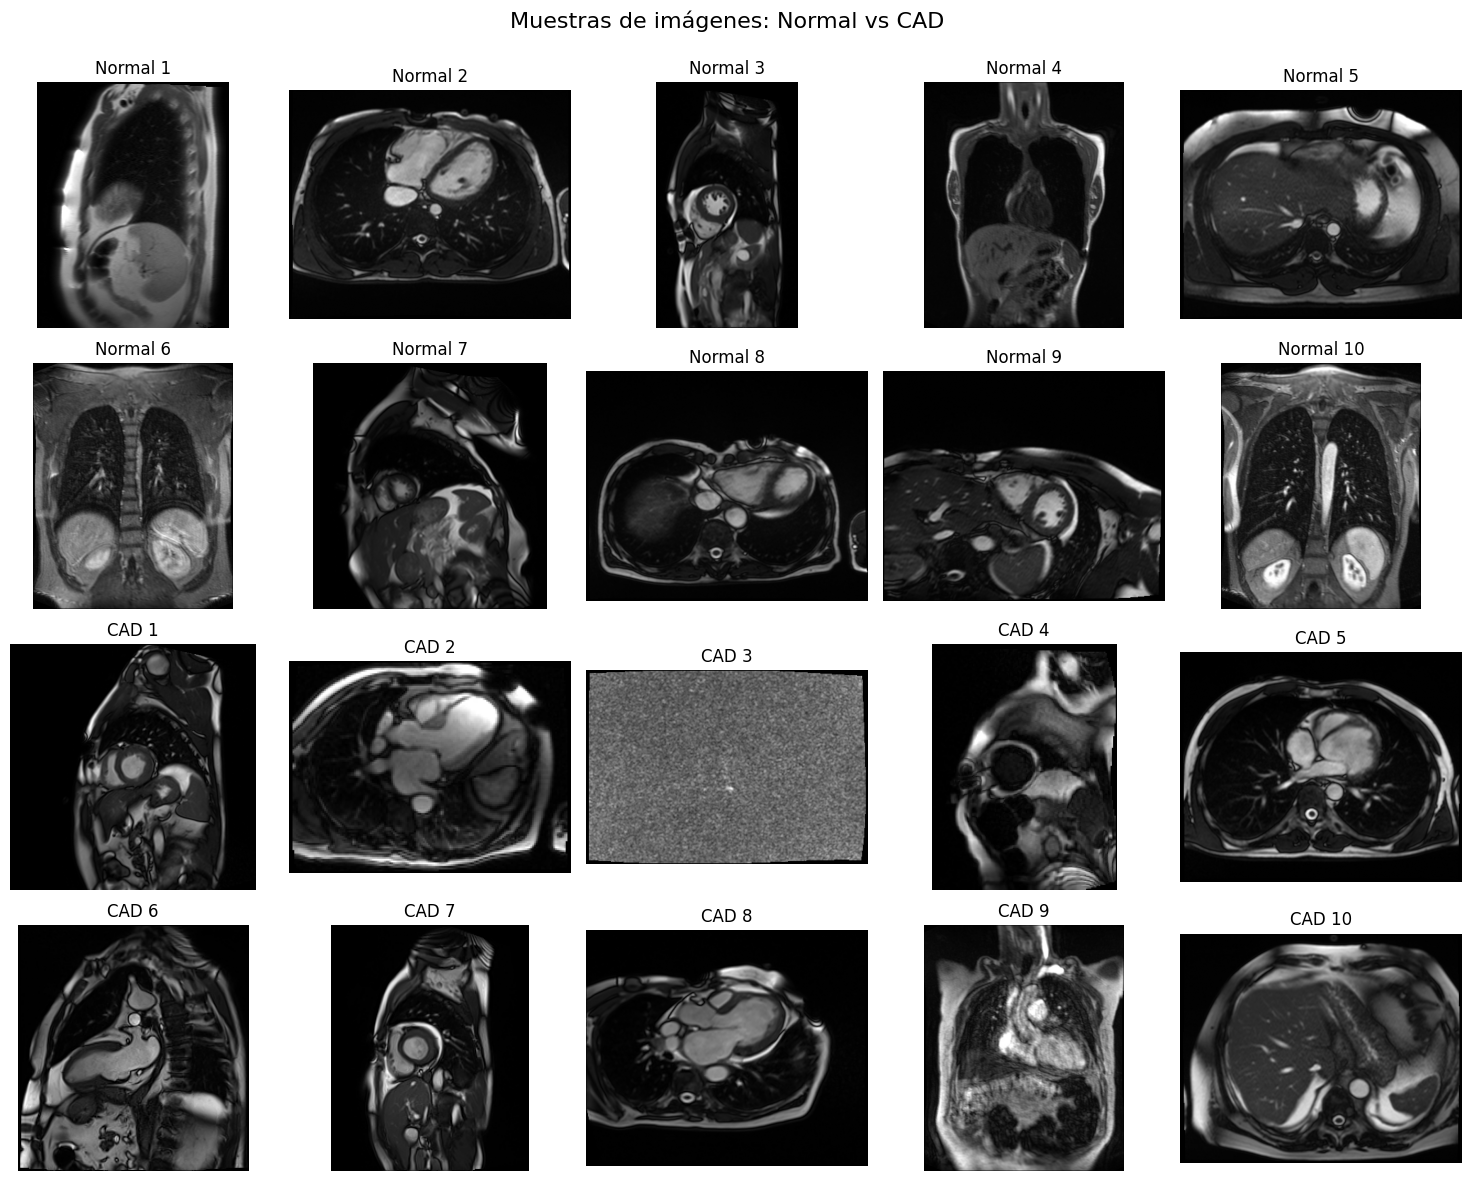

Tamaño de imagen (ejemplo): (200, 256)


In [7]:
# Seleccionar aleatoriamente 10 imágenes de cada clase para visualización
random.seed(42)  # Para reproducibilidad
sample_normal_paths = random.sample(normal_paths, 10)
sample_sick_paths = random.sample(sick_paths, 10)

# Configurar la visualización en una cuadrícula de 4x5 (10 imágenes por clase)
plt.figure(figsize=(15, 12))

# Visualizar imágenes normales
for i, img_path in enumerate(sample_normal_paths):
    plt.subplot(4, 5, i + 1)
    img = Image.open(img_path)
    img_array = np.array(img)
    plt.imshow(img_array, cmap='gray' if len(img_array.shape) == 2 else None)
    plt.title(f"Normal {i+1}")
    plt.axis('off')

# Visualizar imágenes CAD
for i, img_path in enumerate(sample_sick_paths):
    plt.subplot(4, 5, i + 11)  # Empezar en la segunda fila (índice 11)
    img = Image.open(img_path)
    img_array = np.array(img)
    plt.imshow(img_array, cmap='gray' if len(img_array.shape) == 2 else None)
    plt.title(f"CAD {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Muestras de imágenes: Normal vs CAD", fontsize=16)
plt.subplots_adjust(top=0.92)  # Ajustar para dejar espacio al título
plt.show()

# Opcional: Imprimir información sobre el tamaño y formato de las imágenes
sample_img = Image.open(sample_normal_paths[0])
print(f"Tamaño de imagen (ejemplo): {sample_img.size}")

In [ ]:
# Combinar y mezclar todas las rutas
all_paths = normal_paths + sick_paths
all_labels = [0] * len(normal_paths) + [1] * len(sick_paths)

# Mezclar los datos
combined = list(zip(all_paths, all_labels))
random.seed(42)
random.shuffle(combined)
all_paths, all_labels = zip(*combined)

# Dividir en conjuntos de entrenamiento, validación y prueba (70/15/15)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Train: {len(train_paths)} imágenes ({len(train_paths)/len(all_paths):.2%})")
print(f"Validación: {len(val_paths)} imágenes ({len(val_paths)/len(all_paths):.2%})")
print(f"Test: {len(test_paths)} imágenes ({len(test_paths)/len(all_paths):.2%})")

Train: 36205 imágenes (70.00%)
Validación: 7758 imágenes (15.00%)
Test: 7759 imágenes (15.00%)


In [ ]:
# Crear un generador de datos personalizado
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size=32, img_size=(128, 128), shuffle=True, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

        # Crear generador para aumento de datos si es necesario
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        batch_x = []
        batch_y = []

        for i in batch_indexes:
            img_path = self.image_paths[i]
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(self.img_size)
                img_array = np.array(img) / 255.0

                batch_x.append(img_array)
                batch_y.append(self.labels[i])
            except Exception as e:
                print(f"Error procesando {img_path}: {e}")
                continue

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        # Aplicar aumento de datos si está habilitado
        if self.augment and len(batch_x) > 0:
            for i in range(len(batch_x)):
                if np.random.rand() < 0.5:  # Aumento de datos aleatorio
                    params = self.datagen.get_random_transform(batch_x[i].shape)
                    batch_x[i] = self.datagen.apply_transform(batch_x[i], params)

        return batch_x, batch_y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Crear generadores para entrenamiento, validación y prueba
batch_size = 32
img_size = (128, 128)

train_generator = DataGenerator(
    train_paths, train_labels,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=True,
    augment=True  # Solo aplicar aumento de datos al conjunto de entrenamiento
)

val_generator = DataGenerator(
    val_paths, val_labels,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=False,
    augment=False
)

test_generator = DataGenerator(
    test_paths, test_labels,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=False,
    augment=False
)

In [ ]:
# Definir el modelo CNN
def create_cnn_model(input_shape=(128, 128, 3)):
    model = Sequential([
        # Primera capa convolucional
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Segunda capa convolucional
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Tercera capa convolucional
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Cuarta capa convolucional
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Flatten y capas densas
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Salida binaria (CAD o normal)
    ])

    # Compilar el modelo
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

# Crear y mostrar el resumen del modelo
model = create_cnn_model(input_shape=(img_size[0], img_size[1], 3))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,405,217 (20.62 MB)

 Trainable params: 5,402,529 (20.61 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [ ]:
# Definir callbacks para el entrenamiento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1),
    ModelCheckpoint('/kaggle/working/best_cardiac_cad_cnn_model.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
]

# Añadir pesos de clase para dar más importancia a la detección de CAD
class_weights = {0: 1.0, 1: 2.0}  # Dar más peso a la clase CAD para mejorar el recall

# Entrenar el modelo con los generadores (sin los argumentos problemáticos)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights
)

# Evaluar con el conjunto de prueba
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Guardar el modelo final
model.save("/kaggle/working/cardiac_cad_cnn_model_final.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6067 - auc: 0.6426 - loss: 1.2158 - precision: 0.5913 - recall: 0.6638
Epoch 1: val_auc improved from -inf to 0.79278, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 449s 377ms/step - accuracy: 0.6067 - auc: 0.6427 - loss: 1.2157 - precision: 0.5913 - recall: 0.6639 - val_accuracy: 0.5000 - val_auc: 0.7928 - val_loss: 2.2919 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7101 - auc: 0.7960 - loss: 0.8252 - precision: 0.6675 - recall: 0.8308
Epoch 2: val_auc improved from 0.79278 to 0.86362, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 233s 206ms/step - accuracy: 0.7101 - auc: 0.7960 - loss: 0.8252 - precision: 0.6675 - recall: 0.8308 - val_accuracy: 0.5013 - val_auc: 0.8636 - val_loss: 1.7183 - val_precision: 0.5006 - val_recall: 0.9997 - learning_rate: 1.0000e-04
Epoch 3/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7599 - auc: 0.8534 - loss: 0.6834 - precision: 0.7121 - recall: 0.8732
Epoch 3: val_auc improved from 0.86362 to 0.92030, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 233s 206ms/step - accuracy: 0.7599 - auc: 0.8534 - loss: 0.6834 - precision: 0.7121 - recall: 0.8732 - val_accuracy: 0.5186 - val_auc: 0.9203 - val_loss: 1.3040 - val_precision: 0.5095 - val_recall: 0.9995 - learning_rate: 1.0000e-04
Epoch 4/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7978 - auc: 0.8945 - loss: 0.5700 - precision: 0.7459 - recall: 0.8995
Epoch 4: val_auc improved from 0.92030 to 0.96167, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 230s 203ms/step - accuracy: 0.7978 - auc: 0.8945 - loss: 0.5699 - precision: 0.7459 - recall: 0.8995 - val_accuracy: 0.7109 - val_auc: 0.9617 - val_loss: 0.6124 - val_precision: 0.6347 - val_recall: 0.9938 - learning_rate: 1.0000e-04
Epoch 5/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8205 - auc: 0.9156 - loss: 0.5131 - precision: 0.7713 - recall: 0.9069
Epoch 5: val_auc did not improve from 0.96167
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 265s 206ms/step - accuracy: 0.8205 - auc: 0.9156 - loss: 0.5131 - precision: 0.7713 - recall: 0.9069 - val_accuracy: 0.7423 - val_auc: 0.9605 - val_loss: 0.6328 - val_precision: 0.6606 - val_recall: 0.9969 - learning_rate: 1.0000e-04
Epoch 6/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8389 - auc: 0.9324 - loss: 0.4576 - precision: 0.7936 - recall: 0.9205
Epoch 6: val_auc improved from 0.96167 to 0.97352, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 247s 218ms/step - accuracy: 0.8389 - auc: 0.9324 - loss: 0.4576 - precision: 0.7936 - recall: 0.9205 - val_accuracy: 0.7793 - val_auc: 0.9735 - val_loss: 0.4705 - val_precision: 0.6943 - val_recall: 0.9979 - learning_rate: 1.0000e-04
Epoch 7/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8611 - auc: 0.9492 - loss: 0.3967 - precision: 0.8171 - recall: 0.9314
Epoch 7: val_auc improved from 0.97352 to 0.98264, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 232s 205ms/step - accuracy: 0.8611 - auc: 0.9492 - loss: 0.3967 - precision: 0.8171 - recall: 0.9314 - val_accuracy: 0.8809 - val_auc: 0.9826 - val_loss: 0.2781 - val_precision: 0.8132 - val_recall: 0.9889 - learning_rate: 1.0000e-04
Epoch 8/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8758 - auc: 0.9575 - loss: 0.3634 - precision: 0.8303 - recall: 0.9417
Epoch 8: val_auc improved from 0.98264 to 0.99065, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 231s 204ms/step - accuracy: 0.8758 - auc: 0.9575 - loss: 0.3634 - precision: 0.8303 - recall: 0.9417 - val_accuracy: 0.9344 - val_auc: 0.9907 - val_loss: 0.1585 - val_precision: 0.8910 - val_recall: 0.9899 - learning_rate: 1.0000e-04
Epoch 9/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8872 - auc: 0.9640 - loss: 0.3322 - precision: 0.8468 - recall: 0.9460
Epoch 9: val_auc did not improve from 0.99065
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 229s 203ms/step - accuracy: 0.8872 - auc: 0.9640 - loss: 0.3322 - precision: 0.8468 - recall: 0.9460 - val_accuracy: 0.9398 - val_auc: 0.9893 - val_loss: 0.1431 - val_precision: 0.9097 - val_recall: 0.9765 - learning_rate: 1.0000e-04
Epoch 10/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8960 - auc: 0.9692 - loss: 0.3094 - precision: 0.8555 - recall: 0.9508
Epoch 10: val_auc improved from 0.99065 to 0.99218, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 230s 203ms/step - accuracy: 0.8960 - auc: 0.9692 - loss: 0.3094 - precision: 0.8555 - recall: 0.9508 - val_accuracy: 0.9412 - val_auc: 0.9922 - val_loss: 0.1418 - val_precision: 0.9038 - val_recall: 0.9876 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.
243/243 ━━━━━━━━━━━━━━━━━━━━ 58s 239ms/step - accuracy: 0.9490 - auc: 0.9934 - loss: 0.1292 - precision: 0.9160 - recall: 0.9890


Test Loss: 0.1326
Test Accuracy: 0.9475
Test AUC: 0.9931
Test Precision: 0.9129
Test Recall: 0.9894
